In [36]:
# 심층 신경망을 훈련 시의 문제
# 1. 기울기 소실 / 기울기 폭발 문제
# 2. 훈련 데이터 부족 또는 레이블 생성 문제
# 3. 훈련 속도 극단적으로 느림
# 4. 수백만 개의 파라미터를 가진 모델은 훈련 세트에 과대적합될 위험이 크다.
## (특히 훈련 샘플이 충분치 않거나, 잡음이 많을 경우)

## 기울기 소실 과 폭주 문제

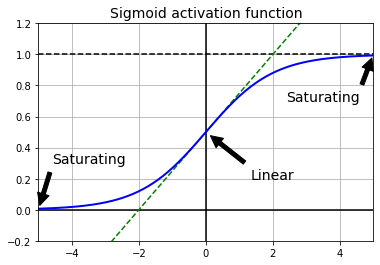

In [3]:
# 오차역전파로 신경망의 모든 파라미터에 대한 오차 함수의 기울기 값을 계산하면
## 경사 하강법 단계에서 이 기울기를 사용하여 각 파라미터를 수정한다.

# 알고리즘이 하위층으로 진행될 수록 기울기값이 점점 작아지는 경우가 많다. => 기울기 소실
# 기울기가 점점 커져서 여러 층이 비정상적으로 큰 가중치로 갱신되면 알고리즘은 발산한다. => 기울기 폭주
## (순환 신경망에서 주로 나타난다.)

# 의심되는 원인 : 로지스틱 시그모이드 활성화 함수 / 가중치 초기화 방법
## => 각 층에서 출력의 분산이 입력의 분산보다 더 크다는 것이 밝혀짐.
## (신경망의 위쪽으로 갈 수록 층을 지날 때마다 분산이 게속 커져 가장 높은 층에서는 활성화함수가 0이나 1로 수렴)
### why? 시그모이드의 평균이 0이 아니고, 0.5이기 때문.

import matplotlib.pyplot as plt
import numpy as np

def logit(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### 글로럿과 He 초기화

In [ ]:
# 케라스는 기본적으로 균등분포의 글로럿 초기화를 사용한다.

import tensorflow.keras as keras
# 초기화 방법들...
[name for name in dir(keras.initializers) if not name.startswith("_")]

In [6]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')
# 층을 만들 때, kernel_initializer='he_uniform' 또는 'he_normal' 을 사용하여 He 초기화를 사용 가능

In [7]:
# fan-out 기반의 균등분포 He 초기화 사용 시 VarianceScaling을 사용할 수 있다.
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='relu', kernel_initializer=init)

### 수렴하지 않는 활성화 함수

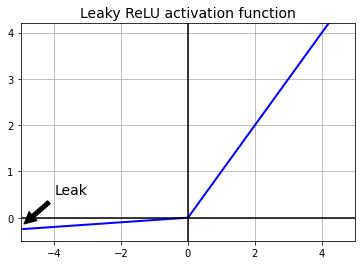

In [8]:
# Relu 함수는 특정 양수값에 수렴하지 않는다는 장점이 있으나,
# 훈련하는 동안 일부 뉴런이 0 이외의 값을 출력하지 않는 문제가 발생할 수 있다.
# (입력의 가중치 합이 음수가 되면 뉴런이 죽는다.) => 경사하강법이 동작하지 않는다.

# 이를 해결하기 위해 LeakyReLu 같은 ReLu 함수의 변종을 사용한다.
# LeakyReLU(z) = max(az , z)
# a : 새는 정도. z < 0 일때의 함수의 기울기. 일반적으로 0.01로 설정한다.

# RReLU : 훈련하는 동안 주어진 범위에서 a 를 무작위로 선택하고 테스트시에는 평균을 사용
## 규제의 역할을 하는 것처럼 보였다고 한다.

# PReLU : a가 '학습되는 동안 학습되는' 

def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [9]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
# LeakyReLU 사용
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

4423680/4422102 [==============================] - 0s 0us/step


In [14]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate = 1e-3))

In [15]:
history = model.fit(X_train, y_train , epochs = 10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.5990 - val_loss: 0.8712
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8332 - val_loss: 0.7122
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7004 - val_loss: 0.6392
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6312 - val_loss: 0.5942
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5934 - val_loss: 0.5609
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5615 - val_loss: 0.5360
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5439 - val_loss: 0.5201
Epoch 8/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5230 - val_loss: 0.5055
Epoch 9/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5108 - val_loss: 0.4974
Epoch 10/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.502

In [16]:
# PReLU 사용
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3))

In [18]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 1.7019 - val_loss: 0.9075
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8572 - val_loss: 0.7158
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7031 - val_loss: 0.6346
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6322 - val_loss: 0.5849
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5852 - val_loss: 0.5545
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5588 - val_loss: 0.5326
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5344 - val_loss: 0.5128
Epoch 8/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5192 - val_loss: 0.4999
Epoch 9/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.5084 - val_loss: 0.4864
Epoch 10/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.494

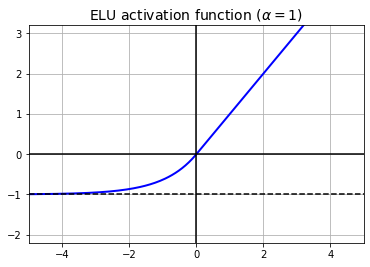

In [19]:
# ELU 활성화 함수
# ReLU 변종의 성능을 넘어섬. 훈련 시간이 줄고, 신경망의 테스트 세트 성능도 더 높았다.

# ReLU 와의 차이점
# 1. z < 0 일때 음수값이 들어오면서 활성화 함수의 평균 출력이 0에 더 가까워진다.
## (기울기 소실 문제 완화)
# 2. z < 0 이어도 기울기가 0이 아니므로 죽은 뉴런이 생기지 않는다.
# 3. alpha가 1 이면 z = 0 에서 급격하게 변동되지 않아 모든 구간에서 매끄러워 경사 하강법의 속도가 올라간다.

# 단점 : 지수함수를 사용하여 ReLU 시리즈보다 계산이 느리다.
# (훈련하는 동안 수렴 속도가 빨라서 느린 계산이 상쇄되지만, 테스트 시에는 ELU가 더 느림.)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [20]:
# 층을 만들 때, 활성화 함수로 지정하여 쉽게 사용 가능하다.
keras.layers.Dense(10, activation="elu")

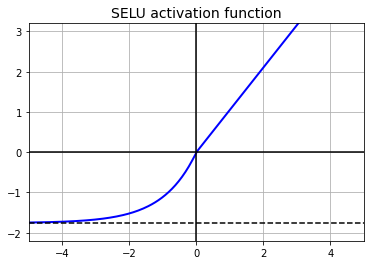

In [23]:
# SELU 활성화 함수 (ELU의 변종)
# 완전연결층만 쌓아서 신경망을 만들고, 모든 은닉층이 SELU 활성화 함수를 사용한다면
# 네트워크가 자기 정규화 된다는 것을 발견하였다.
# 훈련하는 동안 각 층의 출력이 평균 0과 표준편차 1을 유지하는 경향이 있다.
## => 기울기 소실과 폭주 문제를 막아준다.
# 아주 깊은 네트워크에서 다른 활성화 함수보다 뛰어난 성능을 종종 낸다.

# 자기 정규화가 일어나기 위한 조건
# 1. 입력특성이 반드시 표준화 되어야 한다.
# 2. 모든 은닉층의 가중치를 르쿤 정규분포 초기화로 초기화 해야 한다.
# (kernel_initializer = 'lecun_normal')
# 3. 네트워크가 일렬로 쌓은 층으로 구성되어야 한다.
# (순환 신경망, 스킵 연결 에서는 보장되지 않는다.)

from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [25]:
# 층을 만들 때, 활성화 함수로 지정하여 쉽게 사용 가능하다.
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

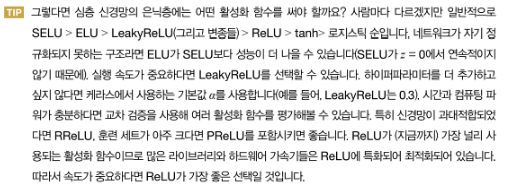

In [26]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

In [27]:
# 입력을 평균 0과 표준편차 1로 바꾼다.
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [28]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 30s 16ms/step - loss: 1.3206 - accuracy: 0.5117 - val_loss: 0.7175 - val_accuracy: 0.7490
Epoch 2/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.6801 - accuracy: 0.7592 - val_loss: 0.6277 - val_accuracy: 0.7776
Epoch 3/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.5669 - accuracy: 0.7956 - val_loss: 0.5567 - val_accuracy: 0.8048
Epoch 4/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.5270 - accuracy: 0.8186 - val_loss: 0.4878 - val_accuracy: 0.8362
Epoch 5/5
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4798 - accuracy: 0.8344 - val_loss: 0.4525 - val_accuracy: 0.8432


### 배치 정규화

In [29]:
# 각 층에서 활성화 함수를 토과하기 전이나 후에 모델에 연산을 하나 추가한다.
# 입력을 원점에 맞추고 정규화한 다음, 각 층에서 두개의 새로운 파라미터로 결괏값의 스케일을 조정하고 이동시킨다.
# 하나는 스케일 조정에, 다른 하나는 이동에 사용한다.
# 많은 경우 신경망의 첫 번째 층으로 배치 정규화를 추가하면 훈련 세트를 표준할 필요가 없다.

# 케라스의 BatchNormalization 층은 이를 자동으로 수행한다.

# 배치 정규화는 규제와 같은 역할을 하여 다른 규제 기법의 필요성을 줄여준다.

# 그러나 배치 정규화는 모델의 복잡도를 키운다. 실행 시간 면에서도 손해이다.
# 층마다 추가되는 계산이 신경망의 예측을 느리게 한다.

# BatchNormalization 층을 추가함으로 써 쉽게 사용할 수 있다.

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

# BatchNormalization 층은 입력마다 네 개의 파라미터를 추가한다.
# 출력 스케일벡터, 출력 이동벡터 , 최종 입력 평균 벡터, 최종 입력 표준편차 벡터

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_112 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_113 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_114 (Dense)            (None, 10)               

In [30]:
# 출력 스케일벡터, 출력 이동벡터는 훈련되고,
# 최종 입력 평균 벡터, 최종 입력 표준편차 벡터는 훈련되지 않는다.
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [33]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs =10 , validation_data = (X_valid , y_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 6ms/step - loss: 1.2098 - accuracy: 0.5973 - val_loss: 0.5622 - val_accuracy: 0.8096
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5966 - accuracy: 0.7956 - val_loss: 0.4843 - val_accuracy: 0.8316
Epoch 3/10
1719/1719 [==============================] - 9s 6ms/step - loss: 0.5243 - accuracy: 0.8147 - val_loss: 0.4465 - val_accuracy: 0.8420
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4837 - accuracy: 0.8298 - val_loss: 0.4240 - val_accuracy: 0.8508
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4647 - accuracy: 0.8372 - val_loss: 0.4093 - val_accuracy: 0.8562
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4376 - accuracy: 0.8478 - val_loss: 0.3963 - val_accuracy: 0.8582
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4267 - accuracy: 0.8494 - val_loss: 0.3868 - val_accu

논문의 저자들은 활성화 함수 이전에 배치 정규화 층을 추가하는 것이 좋다고 조언한다. 
<br>
BatchNormalization 층 이전의 층은 편향을 위한 항이 필요 없다.
<br>
(BatchNormalization 층이 이를 무효화하기 때문)
<br>
use_bias=False 를 지정하여 층을 만든다.
```
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(10, activation="softmax")
])
```



### 기울기 클리핑

In [ ]:
# 역전파 될때 일정 임계값을 넘어서지 못하게 기울기를 잘라내는 것.
# 순환 신경망은 배치정규화를 적용하기 어려워서 이 방법을 많이 사용한다.
# 다른 종류의 네트워크는 배치정규화면 충분하다.

optimizer = keras.optimizers.SGD(clipvalue = 1.0)
model.compile(loss='mse', optimizer= optimizer)
# 기울기 벡터의 모든 원소를 -1.0 과 1.0 사이로 클리핑 한다.
# => 손실의 모든 편미분 값을 -1.0 에서 1.0으로 잘라낸다.
# ex) gradient_vector =  [0.9 , 100.0] ==> [0.9, 1.0]


# 기울기 클리핑이 기울기 벡터의 방향을 바꾸지 못하게 하려면
# clipvalue 대신 clipnorm을 지정하여 노름으로 클리핑 해야 한다.
optimizer = keras.optimizers.SGD(clipnorm=1.0)
# ex) gradient_vector = [0.9, 100.0] = > [0.008999964, 0.9999595]

## 사전훈련된 층 재사용하기

### 케라스를 사용한 전이 학습

In [37]:
# 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망이 이미 있는지 찾아본 다음
## 그 신경망의 하위층을 재사용하는 것을 전이학습이라 한다.
## => 훈련 속도를 크게 높일 뿐만 아니라 필요한 훈련 데이터도 크게 줄여준다.

# 1. 먼저 재사용하는 층을 모두 동결한다.
# 2. 모델을 훈련하고 성능을 평가한다.
# 3. 맨 위에 있는 한두개의 은닉층의 동결을 해제한다.
# 4. 역전파를 통해 가중치를 조정하여 성능이 향상되는지 확인한다.
## (훈련 데이터가 많을 수록 많은 층의 동결을 해제할 수 있다.)
## (재사용 층의 동결을 해제할 때는 학습률을 줄이는 것이 좋다.)
# 5. 여전히 좋은 성능을 낼수 없다면 상위 은닉층들을 제거하고 남은 은닉층을 다시 동결한다.
# 6. 재사용할 은닉층의 적절한 갯수를 찾을 때까지 반복한다.

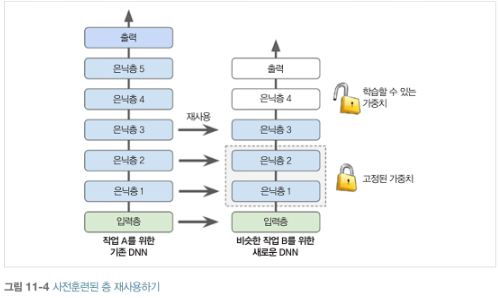

In [38]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

#X_train_A: 샌달과 셔츠(클래스 5와 6)을 제외한 모든 이미지
#X_train_B: 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

In [ ]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_A.fit(X_train_A, y_train_A, epochs=20,
                    validation_data=(X_valid_A, y_valid_A))

In [40]:
model_A.save("my_model_A.h5")

In [ ]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

In [42]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
# 모델 A의 출력층을 제외한 모든 층을 재사용한다.
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))
# 출력층 생성

In [43]:
model_A_clone = keras.models.clone_model(model_A)
# model_B_on_A 를 훈련할 때 model_A 도 영향을 받는다.
# 이를 방지하기 위해 재사용 전 model_A를 클론한다. (구조 복제)
model_A_clone.set_weights(model_A.get_weights())
# 가중치 복사

In [44]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

# 새로운 출력층이 랜덤하게 초기화 되어 있어, 큰 오차를 만들 수 있다.
# => 큰 오차가 재사용된 가중치를 망칠 수 있다.
# => 처음 몇번의 에포크 동안 재사용된 층을 동결하고 새로운 층에게 적절한 가중치를 학습할 시간을 준다.

# 층을 동결하거나 동결을 해제한 후 반드시 모델을 컴파일 해야 한다.

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])

In [45]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))
# 동결된 상태로 4 에포크 동안 학습한다.
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(lr=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

# 4 에포크가 종료 된 후 동결을 해제, 컴파일 한뒤 16 에포크 동안 학습한다.

Epoch 1/4
7/7 [==============================] - 1s 40ms/step - loss: 0.3381 - accuracy: 0.8669 - val_loss: 0.3382 - val_accuracy: 0.8732
Epoch 2/4
7/7 [==============================] - 0s 16ms/step - loss: 0.3117 - accuracy: 0.8927 - val_loss: 0.3251 - val_accuracy: 0.8813
Epoch 3/4
7/7 [==============================] - 0s 16ms/step - loss: 0.3020 - accuracy: 0.8800 - val_loss: 0.3123 - val_accuracy: 0.8884
Epoch 4/4
7/7 [==============================] - 0s 15ms/step - loss: 0.2884 - accuracy: 0.9330 - val_loss: 0.3000 - val_accuracy: 0.8976
Epoch 1/16
7/7 [==============================] - 1s 42ms/step - loss: 0.2415 - accuracy: 0.9408 - val_loss: 0.2357 - val_accuracy: 0.9371
Epoch 2/16
7/7 [==============================] - 0s 16ms/step - loss: 0.2196 - accuracy: 0.9565 - val_loss: 0.1969 - val_accuracy: 0.9503
Epoch 3/16
7/7 [==============================] - 0s 17ms/step - loss: 0.1725 - accuracy: 0.9815 - val_loss: 0.1667 - val_accuracy: 0.9604
Epoch 4/16
7/7 [===============

In [46]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0916 - accuracy: 0.9825


[0.09163115918636322, 0.9825000166893005]

In [47]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.0614 - accuracy: 0.9950


[0.06144269183278084, 0.9950000047683716]

In [48]:
# 전이학습은 작은 완전 연결 네트워크에서는 잘 동작하지 않는다.
# 전이학습은 조금 더 일반적인 특성을 감지하는 경향이 있는 심층 합성곱 신경망에서 잘 동작한다.

### 비지도 사전훈련

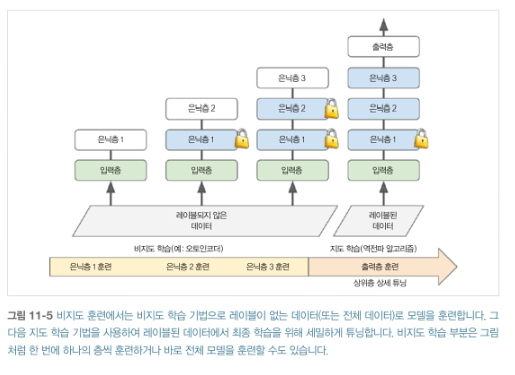

### 보조 작업에서 사전훈련

In [ ]:
# 레이블된 훈련 데이터가 많지 않다면,
# 레이블된 훈련 데이터를 쉽게 얻거나, 생성할 수 있는 보조작업에서 첫번째 신경망을 훈련하는 방법이 있다.
# 이 신경망의 하위층을 실제 작업을 위해 재사용한다.

## 고속 옵티마이저

In [49]:
# 표준적인 경사 하강법 옵티마이저 대신 더 빠른 옵티마이저를 사용할 수있다.
# 모멘텀 최적화, 네스테로프 가속 경사, AdaGrad, RMSProp, Adam, NAdam

### 모멘텀 최적화

In [51]:
# 경사하강법은 이전 기울기값이 얼마였는지 고려하지 않으며, 기울기값이 아주 작으면 매우 느려진다.

# 반면 모멘텀 최적화는 이전 기울기값이 얼마였는지를 중요하게 고려한다.
# 매 반복에서 현재 기울기를 학습률을 곱한 뒤, 모멘텀 벡터에 더하고 이값을 빼는 방식으로 가중치를 갱신한다.
# 기울기를 속도가 아닌 가속도로 사용한다.
# 일종의 마찰저항을 표현하고, 모멘텀이 너무 커지는 것을 막기 위해 모멘텀이라는 하이퍼파라미터 beta 를 사용한다.
# => 0~1 사이로 설정되어야 한다. 일반적인 모멘텀 값은 0.9 이다.

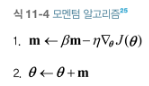

In [50]:
# 케라스에서 모멘텀 최적화를 구현. SGD 옵티마이저를 사용하고, momentum 매개변수를 지정한다.
optimizer = keras.optimizers.SGD(lr=0.001 , momentum=0.9)

### 네스테로프 가속 경사

In [52]:
# 모멘텀 최적화의 변종으로 모멘텀 최적화 보다 거의 항상 더 빠르다.
# 현재 위치를 모멘텀의 방향으로 조금 앞선 곳에서 비용함수의 기울기를 계산한다.

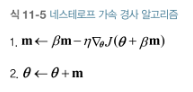

In [53]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### AdaGrad

In [54]:
# 가장 가파른 차원을 따라 기울기 벡터의 스케일을 감소시켜
# 전역 최적점 쪽으로 방향을 잡도록 한다.
# 학습률을 감소시키지만, 경사가 완만한 차원보다 가파른 차원에 대해 더 빠르게 감소된다.
# (적응적 학습률)

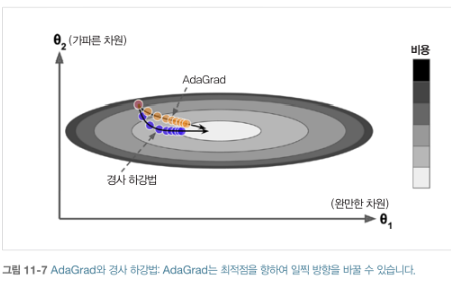

In [ ]:
# 간단한 2차방정식 문제에 대해서는 잘 작동하지만, 신경망을 훈련할 때 너무 일찍 멈추는 경우가 종종 있다.
# 선형 회귀 같은 간단한 작업에는 효과적이나, 심층 신경망에는 사용해선 안된다.